# Random Forest

In [1]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import nltk  # For test pre-processing
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
import scikitplot as skplt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve,auc
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding,LSTM,Dense
import warnings
warnings.filterwarnings('ignore')
import os
import random
import glob

Using TensorFlow backend.


In [2]:
df = pd.read_csv("C:/Users/aivii/programsmm/FP736/corpus/combined_csv1.csv")
df.head(10)

,Unnamed: 0,label,reviews
0,0,1,I went and saw this movie last night after bei...
1,1,1,Actor turned director Bill Paxton follows up h...
2,2,1,As a recreational golfer with some knowledge o...
3,3,1,"I saw this film in a sneak preview, and it is ..."
4,4,1,Bill Paxton has taken the true story of the 19...
5,5,1,"I saw this film on September 1st, 2005 in Indi..."
6,6,1,"Maybe I'm reading into this too much, but I wo..."
7,7,1,I felt this film did have many good qualities....
8,8,1,This movie is amazing because the fact that th...
9,9,1,"""Quitting"" may be as much about exiting a pre-..."


In [3]:
#Remove first column
df = df.drop(df.columns[0], axis=1)
df.rename(columns={'label':'sentiment'}, inplace=True)
df.head(10)

,sentiment,reviews
0,1,I went and saw this movie last night after bei...
1,1,Actor turned director Bill Paxton follows up h...
2,1,As a recreational golfer with some knowledge o...
3,1,"I saw this film in a sneak preview, and it is ..."
4,1,Bill Paxton has taken the true story of the 19...
5,1,"I saw this film on September 1st, 2005 in Indi..."
6,1,"Maybe I'm reading into this too much, but I wo..."
7,1,I felt this film did have many good qualities....
8,1,This movie is amazing because the fact that th...
9,1,"""Quitting"" may be as much about exiting a pre-..."


In [4]:
#df = df.sample(frac=1)

In [5]:
df.head(10)
df.shape

(50000, 2)

In [6]:
print("General stats::")
print(df.info())
print("Summary stats::\n")
print(df.describe())

General stats::
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  50000 non-null  int64 
 1   reviews    50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
None
Summary stats::

          sentiment
count  50000.000000
mean       0.500000
std        0.500005
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000


In [7]:
# number of pos and negative 
df.sentiment.value_counts() # balanced

1    25000
0    25000
Name: sentiment, dtype: int64

In [8]:
reviews = df['reviews']
sentiment = df['sentiment']

In [9]:
# summarize 
print('Classes::\n',np.unique(sentiment))

Classes::
 [0 1]


In [10]:
# split the data into train & test datasets (70:30)
train_reviews = reviews[:35000]
train_sentiment = sentiment[:35000]
test_reviews = reviews[35000:]
test_sentiment = sentiment[35000:]
#Shape of train & test dataset
print('Shape of train dataset::',train_reviews.shape,train_sentiment.shape)
print('Shape of test dataset::',test_reviews.shape,test_sentiment.shape)

Shape of train dataset:: (35000,) (35000,)
Shape of test dataset:: (15000,) (15000,)


In [11]:
#Reshape the array
train_sentiment = train_sentiment.ravel()  
test_sentiment = test_sentiment.ravel()
#Convert categoricals to numeric ones
train_sentiment = train_sentiment.astype('int64')
test_sentiment = test_sentiment.astype('int64')

In [12]:
train_reviews[0]

"I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge."

In [13]:
test_reviews[35001]

"Barman just wanted to make a movie because he wanted to. Just as simple as that, and he succeeded. Not only in his goal, but also in making a wonderful movie, especially visually. He knows how to use pans, slow-motion sequences, tracking shots, crane shots, etc. in a beautiful, smooth way. This gives the movie a very relaxing feel to it.  The story is about the lives of 8 very different characters who have nothing in common except one thing: a party that they all attend to, which also is the turnpoint of this movie. The beauty of this picture lies not in the question how the characters have effect on eachother (in comparance with a similar, of course better movie like Magnolia). I simply don't think that that was Barman's idea. The beauty lies in the different details of experiences that people go through which makes or breaks their lives. Barman is very successful in telling those little stories that describe little experiences. He knows people..... and Antwerp.  The soundtrack of th

Needs to be cleaned more

In [14]:
train_sentiment[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [15]:
test_sentiment[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [16]:
ps= PorterStemmer()
stopwords = set(stopwords.words('english'))

# Define function for data mining
def normalize_reviews(review):
    #Excluding html tags
    data_tags=re.sub(r'<[^<>]+>'," ",review)
    #Remove special characters/whitespaces
    data_special=re.sub(r'[^a-zA-Z0-9\s]','',data_tags)
    #converting to lower case
    data_lowercase=data_special.lower()
    #tokenize review data
    data_split=data_lowercase.split()
    #Removing stop words
    meaningful_words=[w for w in data_split if not w in stopwords]
    #Appply stemming
    text= ' '.join([ps.stem(word) for word in meaningful_words])
    return text

In [17]:
# normaliz3 train and test
norm_train_reviews = train_reviews.apply(normalize_reviews)
norm_test_reviews = test_reviews.apply(normalize_reviews)

In [18]:
norm_train_reviews[0]

'went saw movi last night coax friend mine ill admit reluct see knew ashton kutcher abl comedi wrong kutcher play charact jake fischer well kevin costner play ben randal profession sign good movi toy emot one exactli entir theater sold overcom laughter first half movi move tear second half exit theater saw mani women tear mani full grown men well tri desper let anyon see cri movi great suggest go see judg'

In [19]:
norm_test_reviews[35001]

'barman want make movi want simpl succeed goal also make wonder movi especi visual know use pan slowmot sequenc track shot crane shot etc beauti smooth way give movi relax feel stori live 8 differ charact noth common except one thing parti attend also turnpoint movi beauti pictur lie question charact effect eachoth compar similar cours better movi like magnolia simpli dont think barman idea beauti lie differ detail experi peopl go make break live barman success tell littl stori describ littl experi know peopl antwerp soundtrack movi also excel surpris know barman also succes songwrit musician band deu music sometim hot time relax contribut sunni smooth feel movi time hear funki poprockmelodi give scene strength need there one flaw that last half hour runtim break werent last scene fresh accur scene cant figur beauti sunni movi lift belgian cinema 8 10 breez flow girl hair sunni afternoon make even beauti fresh breez make relax pass crowd parti someon open door breez carri perfum beauti

In [20]:
# create features using bag of words model
cv = CountVectorizer(ngram_range=(1,2))
train_cv = cv.fit_transform(norm_train_reviews)
test_cv = cv.transform(norm_test_reviews)
print('Shape of train_cv::',train_cv.shape)
print('Shape of test_cv::',test_cv.shape)

Shape of train_cv:: (35000, 2177017)
Shape of test_cv:: (15000, 2177017)


### Random Forest model

In [21]:
%%time
# training the classifier
rfc = RandomForestClassifier(n_estimators=20,random_state=42)
rfc = rfc.fit(train_cv,train_sentiment)
score = rfc.score(train_cv,train_sentiment)
print('Accuracy of trained model is ::',score)

Accuracy of trained model is :: 0.9992
Wall time: 3min 40s


In [22]:
%%time
# making predicitions
rfc_predict=rfc.predict(test_cv)

Wall time: 1.62 s


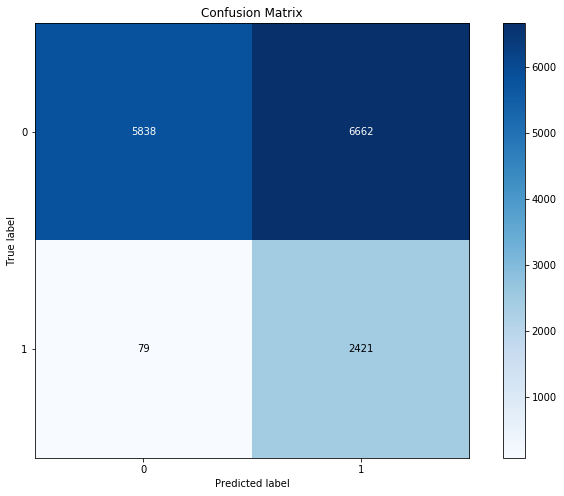

In [23]:
# How accuate our model is?
cm = confusion_matrix(test_sentiment,rfc_predict)

# plot the confusion matrix
skplt.metrics.plot_confusion_matrix(test_sentiment,rfc_predict,normalize=False,figsize=(12,8))
plt.show()

In [24]:
# print classification report for performance metrics
cr=classification_report(test_sentiment,rfc_predict)
print('Classification report is::\n',cr)

Classification report is::
               precision    recall  f1-score   support

           0       0.99      0.47      0.63     12500
           1       0.27      0.97      0.42      2500

    accuracy                           0.55     15000
   macro avg       0.63      0.72      0.53     15000
weighted avg       0.87      0.55      0.60     15000



In [25]:
# ROC curve for Random Forest Classifier
fpr_rf,tpr_rf,threshold_rf=roc_curve(test_sentiment,rfc_predict)
#Area under curve (AUC) score, fpr-False Positive rate, tpr-True Positive rate
auc_rf=auc(fpr_rf,tpr_rf)
print('AUC score for Random Forest classifier::',np.round(auc_rf,3))

AUC score for Random Forest classifier:: 0.718
